In [276]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Feature selection
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

# Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier

from matplotlib import pyplot as plt
    
%matplotlib inline

In [277]:
# The border between high and low
#PERCENT_SPLIT = 0.0037
PERCENT_SPLIT = 0.009

# K best features
K = 100

# Use N last values as features
N = 0

# Use Lagged features
LAG = False
LAG_N = 5

# Time period
period = 1

# Number of rows to read
nrows = 1000000

# Compress time
def sample(df, period):
    period = int(len(df) / period)
    parts = np.array_split(df, period)
    output = []
    for part in parts:
        output.append(part.iloc[0])
    return pd.DataFrame(output)

# Load Data
df = pd.read_csv("/home/ubuntu/data/stocks/SPY_1H.csv", nrows=nrows)

# Ignore premarket data
premarket_df = df[df[df["Time"] >= "08:01"]["Time"] < "09:30"]
df = df[df["Time"] >= "09:30"]

# Use premarket volatility as feature
premarket_group = (premarket_df.groupby("Date").max()["High"] - premarket_df.groupby("Date").min()["Low"]).to_frame()
premarket_group = abs(premarket_group)
premarket_diff = premarket_df[premarket_df["Time"] == "09:29"][["Date", "Close"]]
premarket_diff.index = premarket_diff["Date"]
premarket_diff.drop("Date", axis=1, inplace=True)
premarket_group = premarket_group.join(premarket_diff)

# Fill NaNs with the mean of Close for that day
volatility = premarket_group[0] / premarket_group["Close"]
day = volatility[pd.isnull(volatility) == True].index

for item in day:
    nval = premarket_df[premarket_df["Date"] == item].groupby("Date").mean()["Close"]
    volatility.loc[item] = nval[0]

# Add the premarket volatility as a feature
df["Premarket_Volatility"] = df["Date"]
df["Premarket_Volatility"] = df["Premarket_Volatility"].map(volatility).apply(lambda x: 0 if(pd.isnull(x)) else x)

df["Close"] = df["Close"].apply(lambda x: 1e-7 if x==0 else x)

Change = (df["High"] - df["Low"]) / df["Close"]
Change = abs(Change)

Change.drop(Change.index.values[0], inplace=True)

df.drop(df.index.values[-1], inplace=True)
df["Change"] = Change.values
df["Change"] = df["Change"].apply(lambda x: 1 if x >= PERCENT_SPLIT else 0)
del Change
change_index = len(df.columns.values) - 1

In [278]:
# This will lag all features if enabled
if LAG:
    features = [df]
    dates = [df["Date"]]
    for i in range(LAG_N):
        feature = df[df.columns.drop(["Change", "Time"])].drop(df.index.values[-(i+1):]).copy()
        feature.drop(feature.index.values[0:(LAG_N - (i + 1))], inplace=True)
        dates.append(feature["Date"])
        feature.drop(["Date"], axis=1, inplace=True)
        features.append(feature)
    df.drop(df.index.values[0:LAG_N], inplace=True)
    for item in features:
        item.reset_index(inplace=True, drop=True)
    df = pd.concat(features, ignore_index=True, axis=1)
    cols = df.columns.values.tolist()
    cols[change_index] = "Change"
    df.columns = cols
    
    # Find indices where day is not consistent, these are lag values from different days, remove them.
#     for i in range(len(dates) - 1):
#         dates[i].drop(dates[i].index.values[-(len(dates) - i - 1):], inplace=True)
#     dts = pd.concat(dates, axis=1)
#     off = dts.eq(dts.iloc[:, 0], axis=0).all(1)
#     off = off[off == False]
#     df.drop(off.index.values, inplace=True)


In [279]:
# This will add volatility features for the last N lag values
if LAG:
    features = []
    for i in range(N):
        feature = df["Change"].drop(df.index.values[-(i+1):])
        feature.drop(feature.index.values[0:(N - (i + 1))], inplace=True)
        features.append(feature)

    df.drop(df.index.values[0:N], inplace=True)

    for i in range(N):
        df["lag_" + str(i + 1)] = features[i].values
    cols = df.columns.values.tolist()
    cols[0] = "Date"
    cols[1] = "Time"
    df.columns = cols

In [280]:
# Split data into train and test
train, test = train_test_split(df, test_size=0.3)

# Turn time into distance from "08:00"
X_Train = train.copy()
X_Train.drop(["Change"], axis=1, inplace=True)

if("Date" in X_Train.keys()):
    X_Train.drop(["Date"], axis=1, inplace=True)

X_Train["Time"] = X_Train["Time"].apply(lambda x: ((int(x.split(":")[0]) - 8) * 60 + int(x.split(":")[1])))

#X_Train.drop(["Time"], axis=1, inplace=True)
X_Train = X_Train.values

Y_Train = train["Change"].values

X_Test_Time = test["Time"].values

# Turn time into distance from "08:00"
X_Test = test.copy()
X_Test.drop(["Change"], axis=1, inplace=True)
if("Date" in X_Test.keys()):
    X_Test.drop(["Date"], axis=1, inplace=True)

X_Test["Time"] = X_Test["Time"].apply(lambda x: ((int(x.split(":")[0]) - 8) * 60 + int(x.split(":")[1])))
#X_Test.drop("Time", axis=1, inplace=True)
X_Test = X_Test.values
Y_Test = test["Change"].values

kbest = SelectKBest(score_func=f_regression, k=K)
X_Train = kbest.fit_transform(X_Train, Y_Train)
X_Test = kbest.transform(X_Test)

/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.5/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value enco

In [281]:
# Load classifiers
names = [
    #"Nearest Neighbors",
    #"Linear SVM",
    "Logistic Regression",
    #"RBF SVM",
    #"Decision Tree",
    #"Random Forest",
    #"Neural Net",
    #"AdaBoost",
    #"Naive Bayes",
    "GradientBoostingClassifier",
    "DummyClassifier",
  ]
classifiers = [
    #KNeighborsClassifier(7),
    #SVC(kernel="linear", C=0.025),
    LogisticRegression(),
    #SVC(C=100),
    #DecisionTreeClassifier(max_depth=9),
    #RandomForestClassifier(), #max_depth=9, n_estimators=10, min_samples_leaf=100,
    #MLPClassifier(),
    #AdaBoostClassifier(),
    #GaussianNB(),
    GradientBoostingClassifier(),
    DummyClassifier()
  ]

results = []

# Ignore class 0
indices_0 = np.where(Y_Test == 0)[0]
Y_Test_nozero = np.delete(Y_Test, indices_0, axis=0)
X_Test_Time = np.delete(X_Test_Time, indices_0, axis=0)

# Classify and test
for cname, clf in zip(names, classifiers):
    clf.fit(X_Train, Y_Train)
    Y_Pred = clf.predict(X_Test)
    Y_Pred_nozero = np.delete(Y_Pred, indices_0, axis=0)
    Time_Predictions = pd.DataFrame()
    Time_Predictions["Time"] = X_Test_Time
    Time_Predictions["Predictions"] = (Y_Pred_nozero == Y_Test_nozero)
    Time_Predictions = Time_Predictions.groupby("Time")
    accuracy_per_time = Time_Predictions.sum() / Time_Predictions.count()
    results.append(accuracy_per_time)
    print("########### " + cname + "###########")
    print(classification_report(Y_Test, Y_Pred))
    print("Accuracy Score:")
    print(accuracy_score(Y_Test, Y_Pred))

########### Logistic Regression###########
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      4170
          1       0.83      0.50      0.62       517

avg / total       0.93      0.93      0.93      4687

Accuracy Score:
0.9330061873266482
########### GradientBoostingClassifier###########
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      4170
          1       0.81      0.51      0.63       517

avg / total       0.93      0.93      0.93      4687

Accuracy Score:
0.9332195434179645
########### DummyClassifier###########
             precision    recall  f1-score   support

          0       0.89      0.90      0.90      4170
          1       0.10      0.08      0.09       517

avg / total       0.80      0.81      0.81      4687

Accuracy Score:
0.8135267761894602


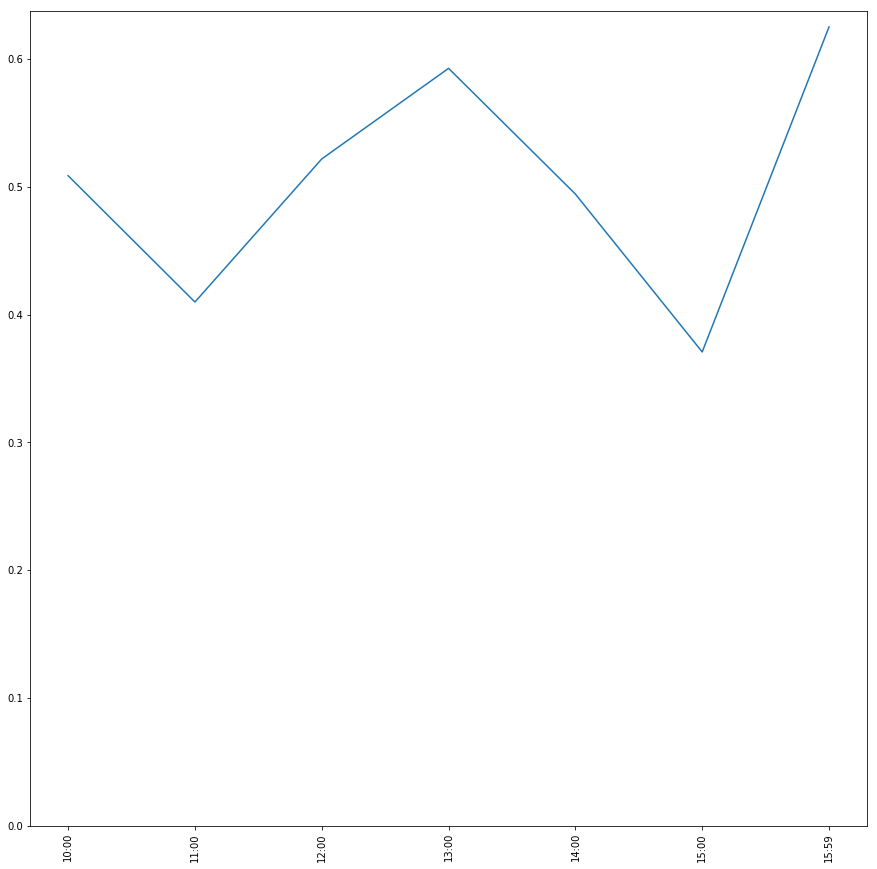

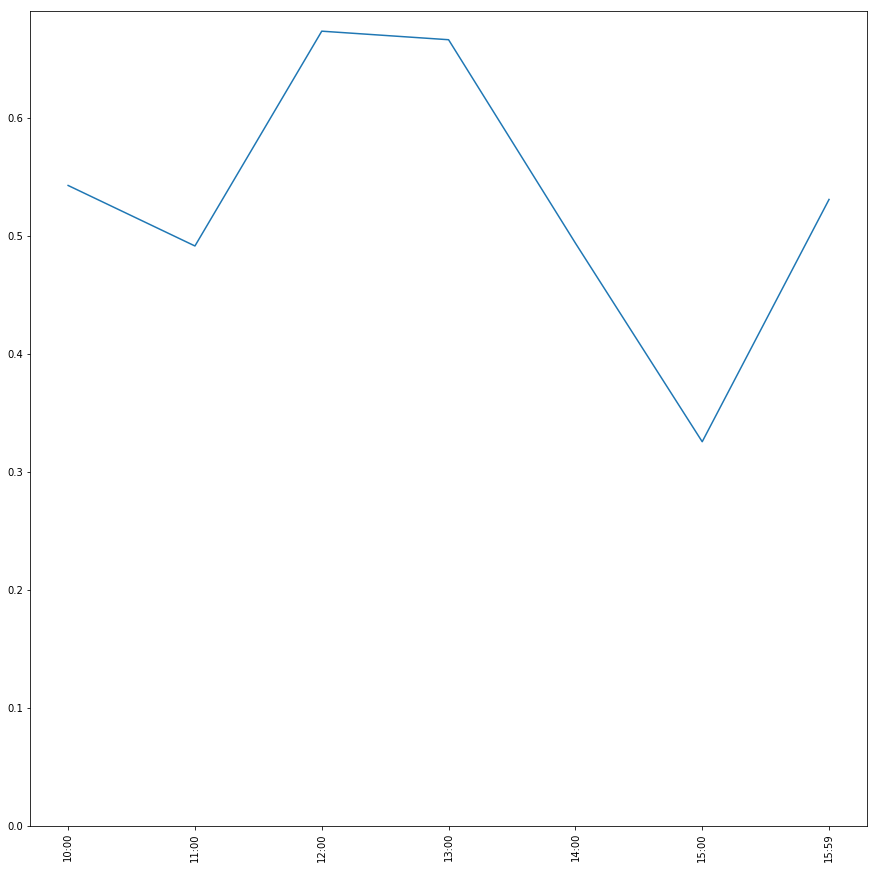

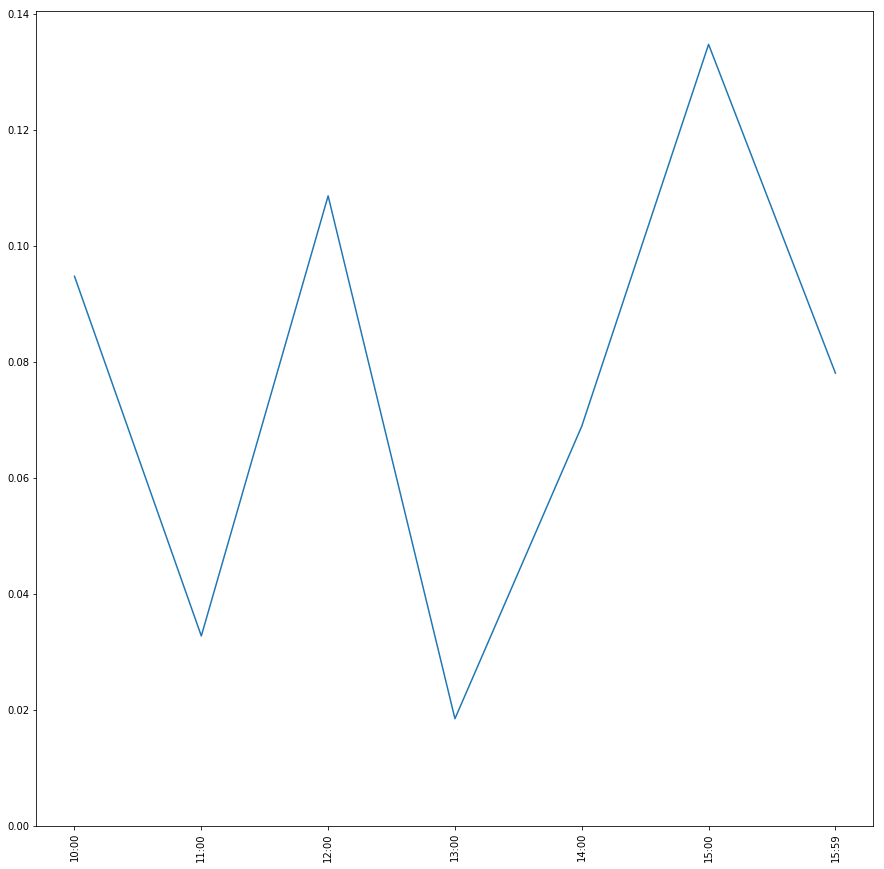

In [282]:
# Visualize the results
for item in results:
    item = sample(item, period)
    x = range(len(item))
    plt.figure(figsize=(15, 15))
    plt.xticks(x, item.index.values, rotation='vertical')
    plt.plot(x, item["Predictions"].values)
    plt.ylim(ymin=0)
    plt.show()

In [283]:
print("The most important feature is feature: #" + str(np.argmax(classifiers[2].feature_importances_)))
print("This is the " + str(train.columns.values[np.argmax(classifiers[2].feature_importances_) + 1]) + " feature of our data")

AttributeError: 'DummyClassifier' object has no attribute 'feature_importances_'